<a href="https://colab.research.google.com/github/MarkoBrie/Image-Classification-with-CNN-and-data-augmentation/blob/main/1_Classification_de_Texte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name='0'></a>
# 0 Sommaire

- [ Sommaire](#0)
- [ 1 - Configurer le noyau et les dépendances nécessaires](#1)
- [ 2 - Préparation du jeu de donnée](#2)
  - [ 2.0 - Charger le jeu de donnée CSV avec catégorie](#2.0)
  - [ 2.1 - Charger les images](#2.1)
  - [ 2.2 - Séparation des catégories](#2.2)
  - [ 2.3 - Stop words](#2.3)
  - [ 2.4 - Stemmer](#2.4)
- [ 3 Définition des fonctions pour la transformation des textes](#3)
  - [ 3.1 Bag-of-words](#3.1)
  - [ 3.2 TF-IDF et CountVectorizer](#3.2)
  - [ 3.3 Word2Vec](#3.3)
  - [ 3.4 BERT](#3.4)
  - [ 3.5 BERT HuggingFace](#3.5)
  - [ 3.6 BERT Tensorflow](#3.6)
  - [ 3.7 USE - Universal Sentence Encoder](#3.7)

<a name='1'></a>
# 1 - Configurer le noyau et les dépendances nécessaires

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

import nltk
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS

# Import des librairies
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import logging

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


<a name='2'></a>
# 2 Préparation du jeu de donnée

<a name='2.0'></a>
## 2.0 Télécharger le jeu de donnée zipped et unzip

In [3]:
import requests
import zipfile
import io
import os

# URL of the zip file
zip_url = 'https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+pre%CC%81traitement+textes+images.zip'

# Destination folder to extract the files
destination_folder = './'

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Download the zip file
response = requests.get(zip_url)

# Check if the download was successful
if response.status_code == 200:
    # Unzip the content
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        zip_ref.extractall(destination_folder)
    print("Zip file successfully downloaded and extracted to :", destination_folder)
else:
    print(f"Failed to download the zip file. Status code: {response.status_code}")

Zip file successfully downloaded and extracted to : ./


<a name='2.1'></a>
## 2.1 Charger les images

In [4]:
# Specify the path to your CSV file
file_path = './Flipkart/flipkart_com-ecommerce_sample_1050.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
#print(df.head())

<a name='2.2'></a>
## 2.2 Category Split

In [5]:
df.product_category_tree[0]

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

In [6]:
def cat_seperator_fct(sentence):
    sentence_clean = sentence.replace('["','')
    first_cat = sentence_clean.split(" >> ")[0]
    return first_cat

df['product_category_tree_1'] = df['product_category_tree'].apply(cat_seperator_fct)
df['product_category_tree_1']

0       Home Furnishing
1             Baby Care
2             Baby Care
3       Home Furnishing
4       Home Furnishing
             ...       
1045          Baby Care
1046          Baby Care
1047          Baby Care
1048          Baby Care
1049          Baby Care
Name: product_category_tree_1, Length: 1050, dtype: object

In [7]:
df.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,product_category_tree_1
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care


In [8]:
df.to_csv("./Flipkart/flipkart_com-ecommerce_sample_1050_with_CAT.csv", index=False)

In [9]:
l_cat = list(set(df['product_category_tree_1']))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(df.iloc[i]['product_category_tree_1'])) for i in range(len(df))]
print(len(y_cat_num))

catégories :  ['Baby Care', 'Computers', 'Kitchen & Dining', 'Home Furnishing', 'Beauty and Personal Care', 'Home Decor & Festive Needs', 'Watches']
1050


In [10]:
df.description

0       Key Features of Elegance Polyester Multicolor ...
1       Specifications of Sathiyas Cotton Bath Towel (...
2       Key Features of Eurospa Cotton Terry Face Towe...
3       Key Features of SANTOSH ROYAL FASHION Cotton P...
4       Key Features of Jaipur Print Cotton Floral Kin...
                              ...                        
1045    Oren Empower Extra Large Self Adhesive Sticker...
1046    Wallmantra Large Vinyl Sticker Sticker (Pack o...
1047    Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048    Buy Wallmantra Medium Vinyl Sticker Sticker fo...
1049    Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...
Name: description, Length: 1050, dtype: object

In [11]:
df['_prodName_Description'] = df['product_name']+df['description']
df.shape

(1050, 17)

In [12]:
#nltk.download()
#pip install nltk

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

<a name='2.3'></a>
## 2.3 Stop words  

- les mots les plus fréquents calculés
- les mots les plus fréquent dans la librarie nltk `nltk.corpus.stopwords.words('english')`



In [14]:
def stop_words_fct(df) :
    # Premièrement, on récupère la fréquence totale de chaque mot
    freq_totale = nltk.Counter()

    tokenizer = nltk.RegexpTokenizer(r'\w+')
    stats, freq = dict(), dict()
    corpus = defaultdict(list)

    # iterate through the DataFrame
    for index, row in df.iterrows():
        corpus[row['uniq_id']] += tokenizer.tokenize(row['description'].lower())

    for k, v in corpus.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}

    for k, v in corpus.items():
        #print('k ', k, ' v ', v)
        freq_totale += freq[k]

    # Deuxièmement on décide manière un peu arbitraire du nombre de mots les plus fréquents à supprimer.
    # On pourrait afficher un graphe d'évolution du nombre de mots pour se rendre compte et
    # avoir une meilleure heuristique.
    most_freq, frequency = zip(*freq_totale.most_common(38))

    # On créé notre set de stopwords final qui cumule ainsi les 38 mots les plus fréquents
    # du corpus ainsi que l'ensemble de stopwords par défaut présent dans la librairie NLTK
    sw = set()
    sw.update(tuple(nltk.corpus.stopwords.words('english')))
    sw.update(most_freq)

    print('number of stop words : ', len(sw))
    return sw

sw = stop_words_fct(df)



number of stop words :  199


<a name='2.4'></a>
## 2.4 Stemmer

In [15]:
from collections import defaultdict
stats, freq = dict(), dict()
corpus = defaultdict(list)
tokenizer = nltk.RegexpTokenizer(r'\w+')
# iterate through the DataFrame
for index, row in df.iterrows():
    corpus[row['uniq_id']] += tokenizer.tokenize(row['description'].lower())
    #print(f"ID: {row['uniq_id']}, Value: {tokenizer.tokenize(row['description'].lower())}")

for k, v in corpus.items():
    #print("k ", k , "  v ", v)
    #print('freq = ', nltk.FreqDist(v))
    freq[k] = fq = nltk.FreqDist(v)
    stats[k] = {'total': len(v), 'unique': len(fq.keys())}

df_stats = pd.DataFrame.from_dict(stats, orient='index')
df_stats.shape

(1050, 2)

<Axes: title={'center': 'Produits par nombre de mots dans description'}>

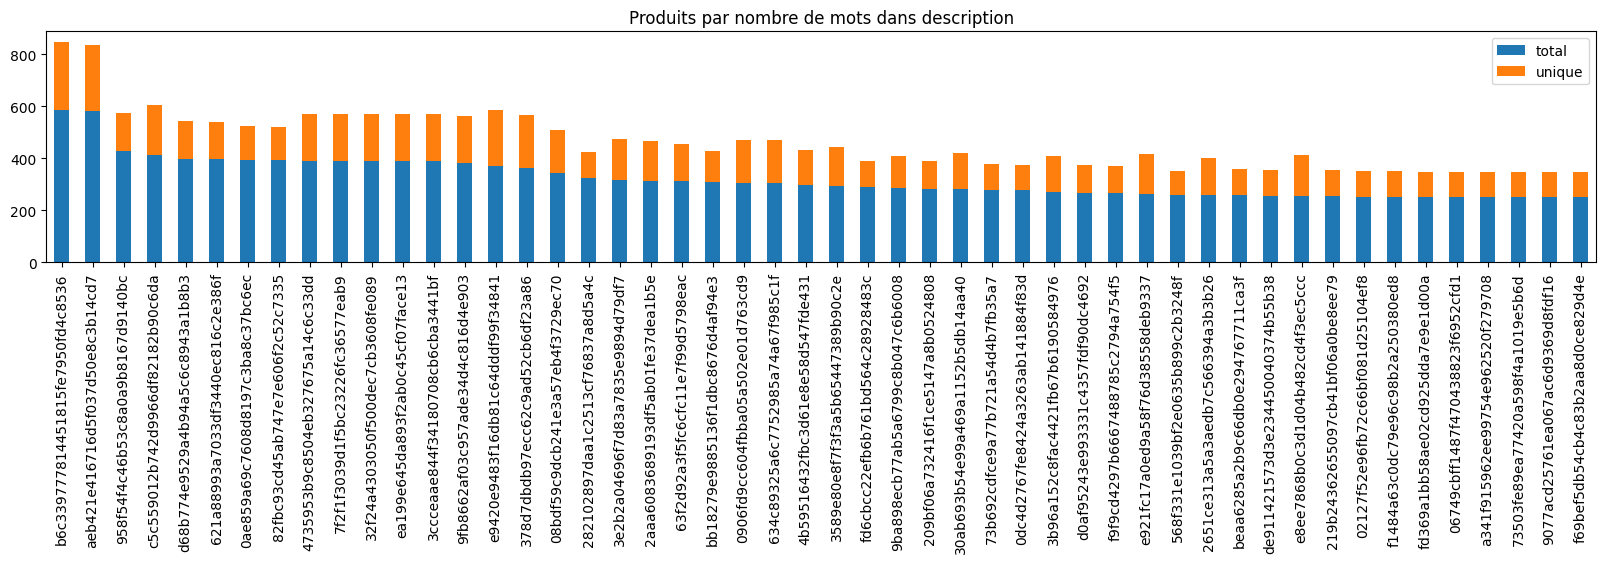

In [16]:
# Affichage des fréquences
df_stats = df_stats.sort_values(by=['total'], ascending=False)
df_stats[:50].plot.bar( title='Produits par nombre de mots dans description',
                   figsize=(20,3),
                    #color=['blue', 'orange'],
                  stacked=True)


<a name='3'></a>
# 3 Feature Extraction: Définition des fonctions pour la transformation des textes


 Représentation de comptage creuse - fréquence d’apparition du mot dans un document, ou vecteur tf-idf d’un document, etc.

Définition des fonctions pour la transformation des documents de texte pour le `Bag-of-words`, `BERT`, `USE`.

In [17]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [18]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import SnowballStemmer

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ').replace('.', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :

    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]

    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@"))
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

# remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma
def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# crude heuristic process that chops off the ends of words
def stemmer_fct(list_words) :
    stemmer = nltk.SnowballStemmer("english")
    stem_w = [stemmer.stem(w) for w in list_words if not w in list(sw)]

    return stem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization and stemmer
def transform_bow_lem_stem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)
    stem_w = stemmer_fct(lem_w)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

df['sentence_bow'] = df['description'].apply(lambda x : transform_bow_fct(x))
df['sentence_bow_lem'] = df['description'].apply(lambda x : transform_bow_lem_fct(x)) # Word2Vec
df['sentence_bow_lem_stem'] = df['description'].apply(lambda x : transform_bow_lem_stem_fct(x))
df['sentence_dl'] = df['description'].apply(lambda x : transform_dl_fct(x)) # BERT, USE

df['sentence_bow_lem_stem'] = df['description'].apply(transform_bow_lem_stem_fct)
df.shape

(1050, 21)

In [19]:
df['description'][0]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

In [20]:
df['sentence_bow_lem_stem'][0]

'key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain 213 height pack price 899 this curtain enhances look interior this curtain made 100 high quality polyester fabric feature eyelet style stitch metal ring make room environment romantic loving this curtain ant wrinkle anti shrinkage elegant apparance give home bright modernistic appeal design the surreal attention sure steal heart these contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount sunlight specification elegance polyester multicolor abstract eyelet door curtain 213 height pack general brand elegance designed for door type eyelet model name abstract polyester door curtain set model duster25 color multicolor di

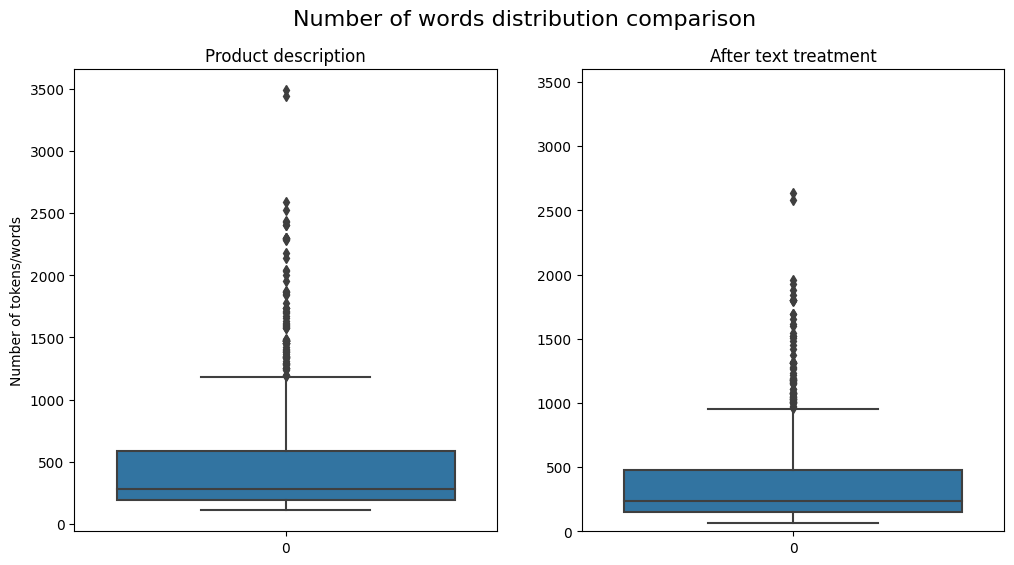

In [87]:
tmp = df['description'].str.len()
tmp2 = df['sentence_bow_lem_stem'].str.len()
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(12,6))
plt.ylim(0, 3600)
sns.boxplot(data=tmp, ax=axes[0]).set(title='Product description')
axes[0].set_ylabel('Number of tokens/words')
fig.suptitle('Number of words distribution comparison', fontsize=16)
sns.boxplot(data=tmp2, ax=axes[1]).set(title='After text treatment')
plt.show()
df['_desc_len_txt'] = tmp

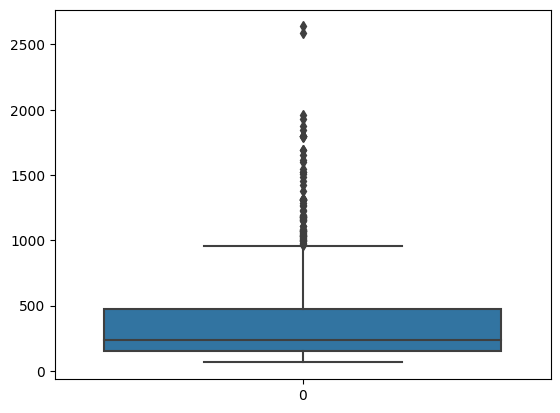

In [76]:
tmp = df['sentence_bow_lem_stem'].str.len()
#fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(24,8))
sns.boxplot(tmp)#, ax=axes[0])
#sns.displot(tmp)#, ax=axes[1])
plt.show()
df['_len_txt'] = tmp

In [68]:
df.head(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,overall_rating,brand,product_specifications,product_category_tree_1,_prodName_Description,sentence_bow,sentence_bow_lem,sentence_bow_lem_stem,sentence_dl,_len_txt
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Elegance Polyester Multicolor Abstract Eyelet ...,key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...,1106
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Sathiyas Cotton Bath TowelSpecifications of Sa...,specifications sathiyas cotton bath towel bath...,specification sathiyas cotton bath towel bath ...,specification sathiyas cotton bath towel bath ...,specifications of sathiyas cotton bath towel (...,395
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,...,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Eurospa Cotton Terry Face Towel SetKey Feature...,key features eurospa cotton terry face towel s...,key feature eurospa cotton terry face towel se...,key feature eurospa cotton terry face towel se...,key features of eurospa cotton terry face towe...,998
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,...,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,SANTOSH ROYAL FASHION Cotton Printed King size...,key features santosh royal fashion cotton prin...,key feature santosh royal fashion cotton print...,key feature santosh royal fashion cotton print...,key features of santosh royal fashion cotton p...,757
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,...,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,Jaipur Print Cotton Floral King sized Double B...,key features jaipur print cotton floral king s...,key feature jaipur print cotton floral king si...,key feature jaipur print cotton floral king si...,key features of jaipur print cotton floral kin...,980


<ipython-input-22-a9af3d6d74e8>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tmp, ax=axes[1])


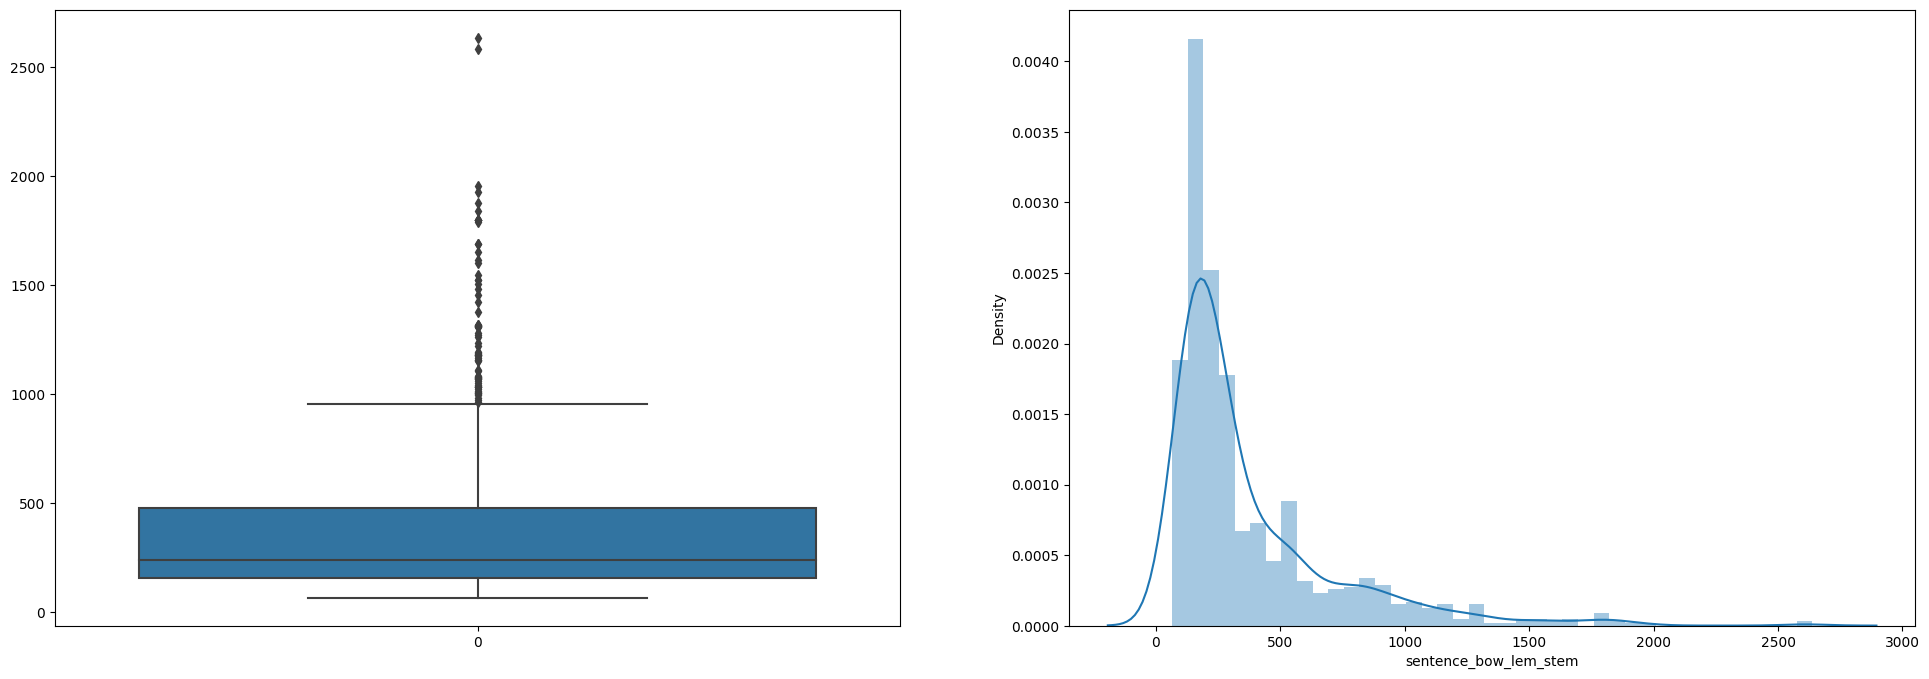

In [22]:
tmp = df['sentence_bow_lem_stem'].str.len()
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(24,8))
sns.boxplot(tmp, ax=axes[0])
sns.distplot(tmp, ax=axes[1])
plt.show()
df['_len_txt'] = tmp

In [23]:
#df.sentence_bow_lem_stem.values

In [24]:
def display_tokens_info(tokens_info):
    """ Display info about tokens """
    tokens_info = word_tokenize(tokens_info)
    print(f" nb tokens {len(tokens_info)} , nb tokens unique {len(set(tokens_info))}")
    print(set(tokens_info))

In [25]:
df['sentence_bow_lem_stem'][0]

'key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain 213 height pack price 899 this curtain enhances look interior this curtain made 100 high quality polyester fabric feature eyelet style stitch metal ring make room environment romantic loving this curtain ant wrinkle anti shrinkage elegant apparance give home bright modernistic appeal design the surreal attention sure steal heart these contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount sunlight specification elegance polyester multicolor abstract eyelet door curtain 213 height pack general brand elegance designed for door type eyelet model name abstract polyester door curtain set model duster25 color multicolor di

In [26]:
display_tokens_info(df['sentence_bow_lem_stem'][0])

 nb tokens 158 , nb tokens unique 107
{'joyous', 'surreal', 'softly', 'attention', 'give', 'enhances', 'appeal', 'sale', 'ring', 'beauty', 'valance', 'for', 'anti', 'style', 'general', 'elegant', 'the', 'create', 'model', 'metal', 'amount', 'good', 'interior', 'this', 'romantic', 'number', 'stitch', 'color', 'dimension', 'want', 'set', 'get', 'specification', 'ant', 'welcome', 'designed', 'print', 'given', 'special', 'loving', 'room', 'right', 'steal', 'environment', 'material', 'shrinkage', 'design', 'feature', 'fabric', 'first', 'sun', 'look', 'multicolor', 'morning', 'high', 'heart', 'these', 'floral', 'abstract', 'curtain', 'light', 'make', 'made', 'name', 'price', 'brand', '100', 'close', 'ray', 'door', 'eyelet', 'quality', '213', 'wish', 'whole', 'apart', 'moment', 'apparance', 'content', 'length', 'sunlight', 'key', 'soothing', 'sure', 'draw', 'elegance', '899', 'package', 'polyester', 'type', 'bring', 'evening', 'wrinkle', 'duster25', 'body', 'world', 'home', 'contemporary', 'p

In [27]:
very_raw_corpus = "".join(df.description.values)
print(len(very_raw_corpus))
display_tokens_info(very_raw_corpus)

497512
 nb tokens 90712 , nb tokens unique 8476
{'1,390', 'Layered', '14inch', '2115', '331', 'Nail', 'NECKSpecifications', 'Altimeter', 'pen', 'Transcend', 'dv5-1015nr', 'Size', 'screwdriver', 'frizz', 'handle', 'Olvin', 'gown', 'Nights', 'mantra', 'All', 'Cocovey', 'Soex', 'Jharoka', 'wax', 'From', 'Handpainted', 'Num', 'Designs', 'Money', 'next', 'According', 'Arabian', 'DamageSpecifications', 'Smoothing', 'spacious', 'Established', 'task', 'Esteem', 'Grey', 'extra', '1,325', 'Artistic', 'aluminium', 'buildable', 'Rs.1333', '666BTP_XN', 'Rs.519', 'Creation', 'of5', '160/2gb/DDR2', '1TB/', 'Beaded', 'yourself', 'branded', 'Simple', 'Wok', '404', 'DDR2', 'skins', 'paint', '630', 'Pschedelic', 'way', 'Human', 'Sciences', 'Mild', '-Trim', 'while', 'arts', '5900', 'buttery', 'style.', 'SHUVAM20PCFTSETASSORTED', 'increasing', 'Genuine', 'Attractive', 'shade', 'components', 'Machine', 'cable', 'sky', '279', 'BDOA507SPK', '239', 'Fun', 'Disney', 'Cardboard', 'doraemon', 'doctors', 'Units', 

In [28]:
corpus_total = "".join(df.sentence_bow_lem_stem.values)
print(len(corpus_total))
display_tokens_info(corpus_total)

393391
 nb tokens 57701 , nb tokens unique 5881
{'1,390', 'abkl_pl_pnk_pnk', '14inch', '2115', '331', 'elegent', 'pen', 'cmpoppins', 'screwdriver', '005', 'reflects', 'frizz', 'handle', 'gown', 'mantra', 'disinfectant', 'wax', 'goldencollections', 'elasticised', 'next', 'twisting', 'crystle01', 'wallsk', 'spacious', 'task', 'calorie', 'antimicrobial', 'extra', 'deliveryrega', '1,325', 'aluminium', 'buildable', 'of5', 'yourself', 'branded', 'ouality', 'coming', '404', 'paint', '630', 'peppermint', 'way', '440', 'while', 'bib', 'goldbedi', '5900', 'station', 'buttery', 'posterkey', 'increasing', 'fanbuy', 'liabilitykey', 'shade', 'cable', 'density', 'sky', '279', 'anodised', '239', 'doraemon', 'eternity', 'spring', 'artifact', 'drying', 'timepiece', 'pmr1174', 'differ', 'extravagant', 'saucer', '1lunch', 'adding', 'bankura', 'quits', 'jali', 'eyelet', 'within', 'safest', 'travelling', '5,700', 'jbc', '523', '825000000000001', 'aiding', 'stage', 'power', 'pile', 'mocktails', '419', 'guara

In [29]:
display_tokens_info(df.description[0])

 nb tokens 247 , nb tokens unique 146
{'joyous', 'surreal', 'softly', 'attention', '2', 'enhances', 'appeal', 'with', 'Ring.It', 'These', 'and', 'In', 'an', 'from', 'Curtains', 'Material', 'beauty', 'General', 'makes', 'valance', 'anti', 'that', 'your', 'style', 'Specifications', 'when', 'the', 'have', 'elegant', 'create', 'filters', 'amount', 'sunlight.', 'in', 'good', 'Duster25', 'romantic', '.', 'fabric.It', 'stitch', 'prints', 'Color', 'Type', 'want', 'Abstract', 'get', 'welcome', 'rays', 'features', ':', 'Height', 'Dimensions', 'to', 'given', 'special', 'Set', 'most', 'room', 'right', 'Package', 'steal', 'environment', 'cm', 'shrinkage', 'Designed', 'by', 'first', 'Of', ')', 'sun', 'look', 'morning', 'high', 'Elegance', 'Features', 'ant-', 'these', 'Sales', 'curtain', 'light', 'made', '&', '100', 'Rs', 'close', 'eyelet', 'quality', '213', 'apparance.Give', 'them', 'wish', 'whole', 'For', '(', ',', 'apart', 'interiors.This', 'so', 'Body', 'designs', 'moments', 'Design', 'soothing',

<a name='3.1'></a>
## 3.1 Bag-of-words

Le modèle de `bag-of-words` est une technique simple d'incorporation de documents basée sur la fréquence des mots. Conceptuellement, nous considérons l'ensemble du document comme un "sac" de mots, plutôt qu'une séquence. Nous représentons le document simplement par la fréquence de chaque mot. Par exemple, si nous avons un vocabulaire de 1000 mots, alors l'ensemble du document sera représenté par un vecteur de 1000 dimensions, où la i-ème entrée du vecteur représente la fréquence du i-ème mot du vocabulaire dans le document.  

En utilisant cette technique, nous pouvons incorporer tout un ensemble de documents et les soumettre à différentes algorithmes d'apprentissage automatique. Étant donné que cette incorporation est très basique, elle ne fonctionne pas très bien pour des tâches complexes. Cependant, elle convient bien aux problèmes de classification simples, et sa simplicité et sa facilité d'utilisation en font un choix attrayant.

In [30]:
pd.set_option('display.max_rows', None)
tmp = pd.Series(word_tokenize(corpus_total)).value_counts()
tmp.head(1000)

product             863
only                717
free                617
for                 611
cash                564
shipping            564
genuine             564
replacement         559
price               558
day                 548
com                 468
mug                 448
feature             404
online              396
flipkart            392
color               362
watch               354
the                 353
type                325
baby                321
material            312
set                 307
cotton              297
box                 295
specification       292
guarantee           289
general             288
pack                267
package             267
design              266
analog              262
sale                262
number              254
warranty            249
quality             245
detail              242
buy                 240
girl                238
brand               238
laptop              234
inch                230
best            

In [31]:
# Create a CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the corpus
X = vectorizer.fit_transform(word_tokenize(corpus_total))

# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame for better visualization (optional)
df_bow = pd.DataFrame(X.toarray(), columns=feature_names)
print(df_bow.shape)
print(df_bow)

(57701, 5819)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<a name='3.1.1'></a>
## 3.1.1 TF-IDF Term Frequency - Inverse Document Frequency

In [32]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)

    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des déscription de produit par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des déscriptions par clusters')

    plt.show()
    print("ARI : ", ARI)

###CountVectorizer and TfidfVectorizer Creation:
- `max_df=0.95` ignores terms that appear in more than 95% of the documents.
- `min_df=1` ignores terms that appear in only one document.

In [33]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(df[feat])
ctf_fit = ctf.fit(df[feat])
#values = tfidf.fit_transform(df[feat].values())

cv_transform = cvect.transform(df[feat])
ctf_transform = ctf.transform(df[feat])

### Métriques d'évalutation

In [34]:
# Step 1: Initialize an empty DataFrame
columns = ['Method', 'ARI']
methods_ARI = pd.DataFrame(columns=columns)

### Segmentation avec Kmeans, TSNE, ARI

In [35]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
new_row = ['1 CountVectorizer', ARI]
methods_ARI.loc[len(methods_ARI)] = new_row
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)

new_row = ['2 Tf-idf', ARI]
methods_ARI.loc[len(methods_ARI)] = new_row

CountVectorizer : 
-----------------
ARI :  0.3745 time :  21.0

Tf-idf : 
--------
ARI :  0.5389 time :  37.0


In [36]:
methods_ARI

,Method,ARI
0,1 CountVectorizer,0.3745
1,2 Tf-idf,0.5389


### Graphiques TSNE

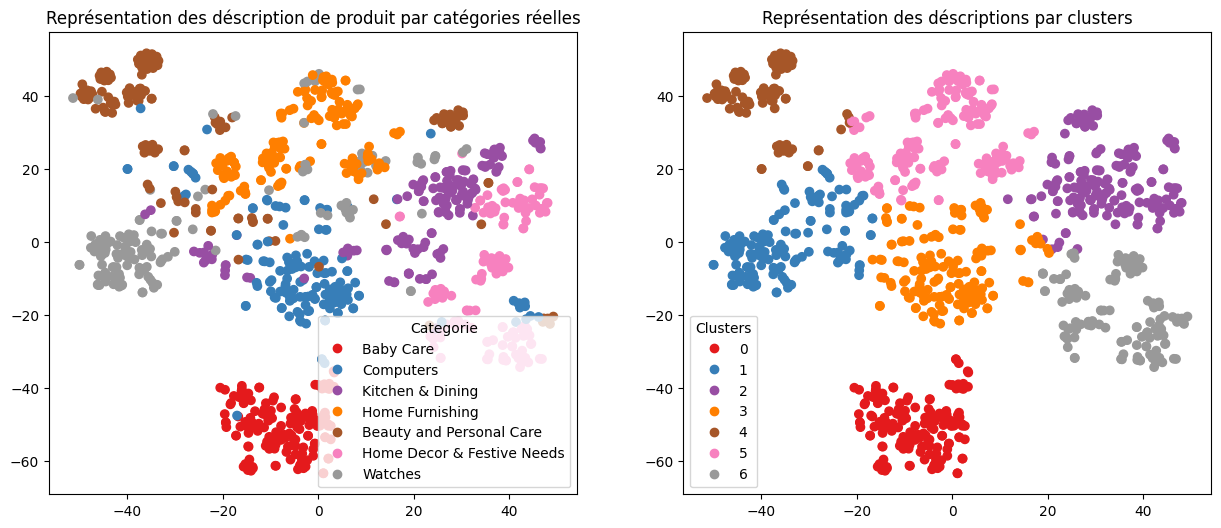

ARI :  0.5389


In [37]:
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

<a name='3.3'></a>
## 3.3 Word2Vec

word2vec dense - le mot possède une représentation dans un espace qui le positionne en fonction des mots adjacents

In [38]:
pip install gensim

In [39]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

In [40]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = df['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [41]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4688
Word2Vec trained


In [42]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post')

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4689


### Création de la matrice d'embedding

In [43]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0

for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4689, 300)


### Création du modèle d'embedding

In [44]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           1406700   
                                                                 
 global_average_pooling1d (  (None, 300)               0         
 GlobalAveragePooling1D)                                         
                                                                 
Total params: 1406700 (5.37 MB)
Trainable params: 1406700 (5.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Exécution du modèle Word2Vec

In [45]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 1s 9ms/step


(1050, 300)

### Segmentation avec Kmeans, TSNE et ARI

In [46]:
ARI, X_tsne, labels = ARI_fct(embeddings)

new_row = ['3 Word2Vec', ARI]
methods_ARI.loc[len(methods_ARI)] = new_row

ARI :  0.2818 time :  63.0


### Graphique TSNE

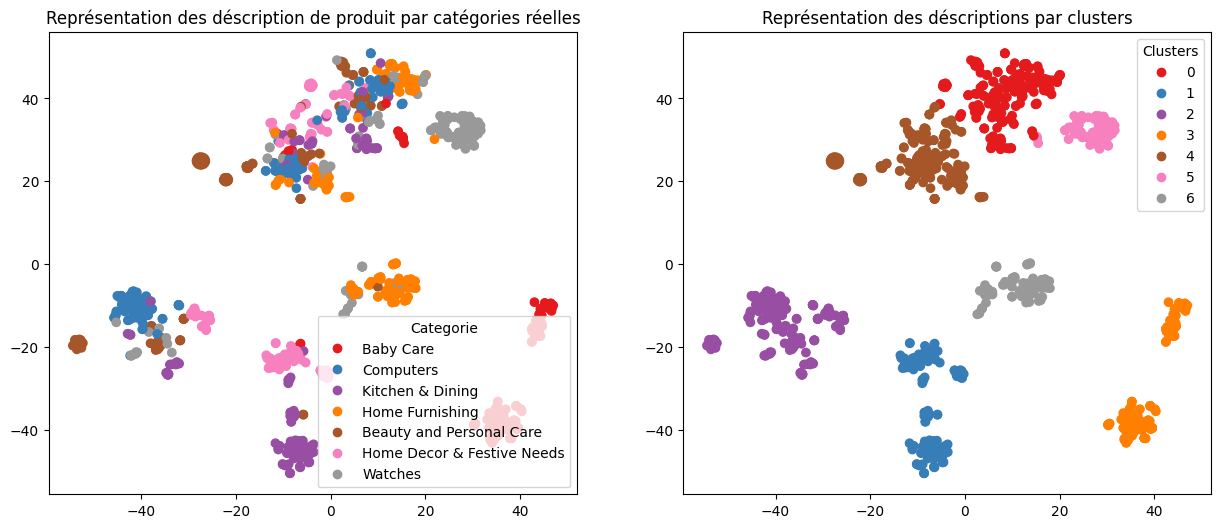

ARI :  0.2818


In [47]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

<a name='3.4'></a>
## 3.4 BERT

In [48]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import TFAutoModel
from transformers import AutoTokenizer
#from transformers import *

os.environ["TF_KERAS"]='1'

In [49]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.15.0
2.15.0
Num GPUs Available:  0
True


### BERT : Fonctions communes

In [50]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length):
    input_ids = []
    token_type_ids = []
    attention_mask = []
    bert_inp_tot = []

    for sent in sentences:
        # Encodage de la phrase avec le tokenizer BERT
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens=True,
                                              max_length=max_length,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")

        # Ajout des résultats aux listes respectives
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    # Conversion des listes en tableaux NumPy
    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    # Retourne les tableaux NumPy et la liste complète des entrées BERT
    return input_ids, token_type_ids, attention_mask, bert_inp_tot



# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
                                                                      bert_tokenizer, max_length)

        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids,
                                 "input_mask" : attention_mask,
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot

<a name='3.5'></a>
## 3.5 BERT HuggingFace

### 'bert-base-uncased'

In [51]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df['sentence_dl'].to_list()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [52]:
# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='HF')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

1/1 [==============================] - 2s 2s/step
temps traitement :  303.0


In [53]:
ARI, X_tsne, labels = ARI_fct(features_bert)

new_row = ['4 BERT-base-uncased Huggingface', ARI]
methods_ARI.loc[len(methods_ARI)] = new_row

ARI :  0.3267 time :  15.0


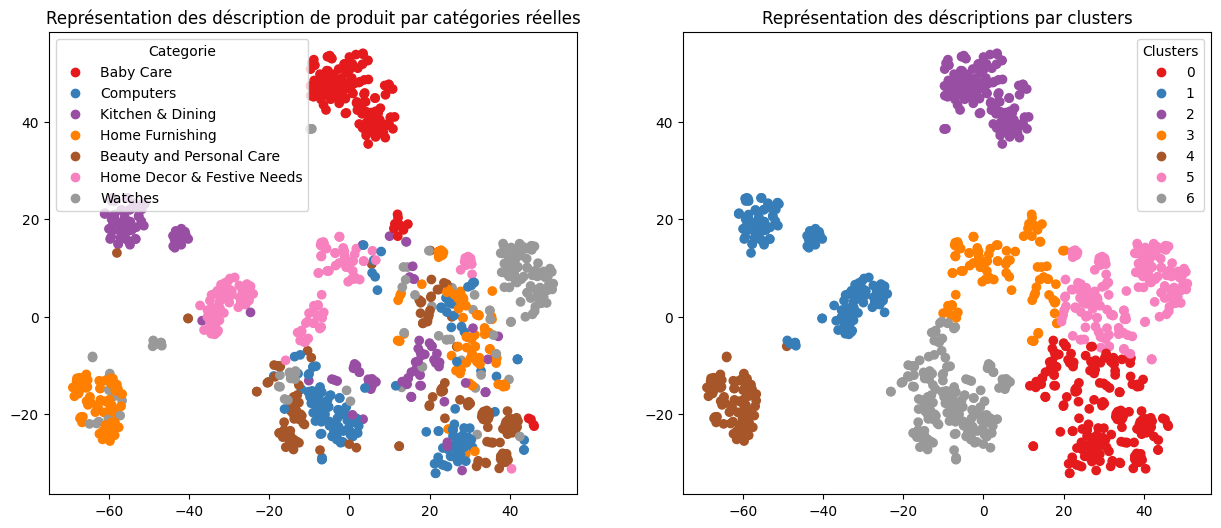

ARI :  0.3267


In [54]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

<a name='3.6'></a>
## 3.6 BERT hub Tensorflow

In [55]:
pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 15.4 MB/s eta 0:00:00


In [56]:
import tensorflow_hub as hub
import tensorflow_text

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [57]:
#sentences = data_T['sentence_dl'].to_list()

In [58]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='TFhub')

temps traitement :  267.0


ARI :  0.3259 time :  15.0


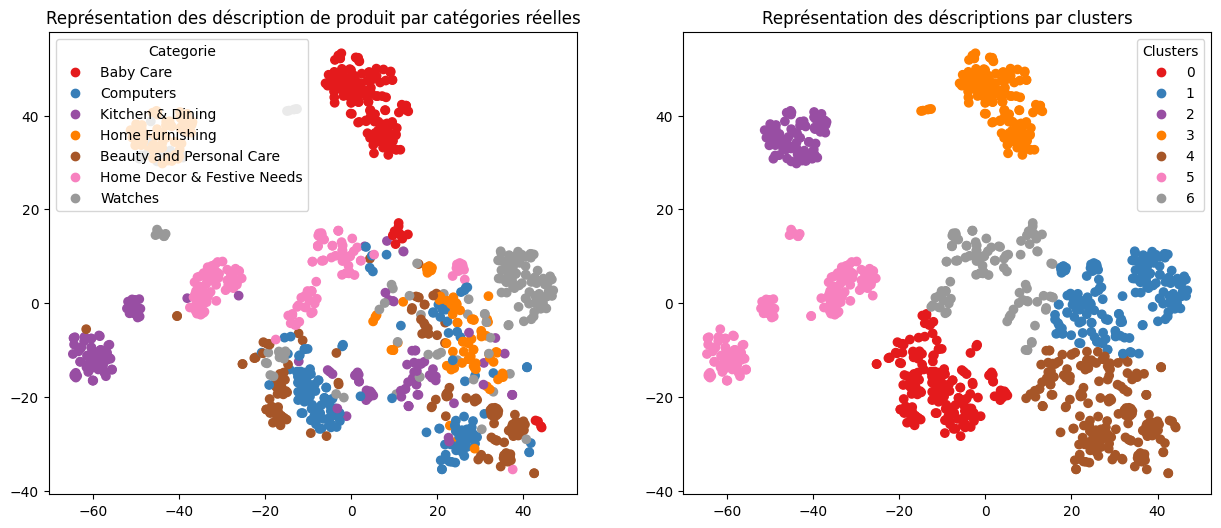

ARI :  0.3259


In [59]:
ARI, X_tsne, labels = ARI_fct(features_bert)

new_row = ['5 BERT Tensorflow', ARI]
methods_ARI.loc[len(methods_ARI)] = new_row

TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

<a name='3.7'></a>
## 3.7 USE - Universal Sentence Encoder

In [60]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
#from transformers import *

os.environ["TF_KERAS"]='1'

In [61]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.15.0
2.15.0
Num GPUs Available:  0
True


In [62]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [63]:
sentences

['key features of elegance polyester multicolor abstract eyelet door curtain floral curtain , elegance polyester multicolor abstract eyelet door curtain ( 213 cm in height , pack of 2 ) price : rs 899 this curtain enhances the look of the interiors this curtain is made from 100 % high quality polyester fabric it features an eyelet style stitch with metal ring it makes the room environment romantic and loving this curtain is ant wrinkle and anti shrinkage and have elegant apparance give your home a bright and modernistic appeal with these designs the surreal attention is sure to steal hearts these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening , you create the most special moments of joyous beauty given by the soothing prints bring home the elegant curtain that softly filters light in your room so that

ARI :  0.4226 time :  18.0


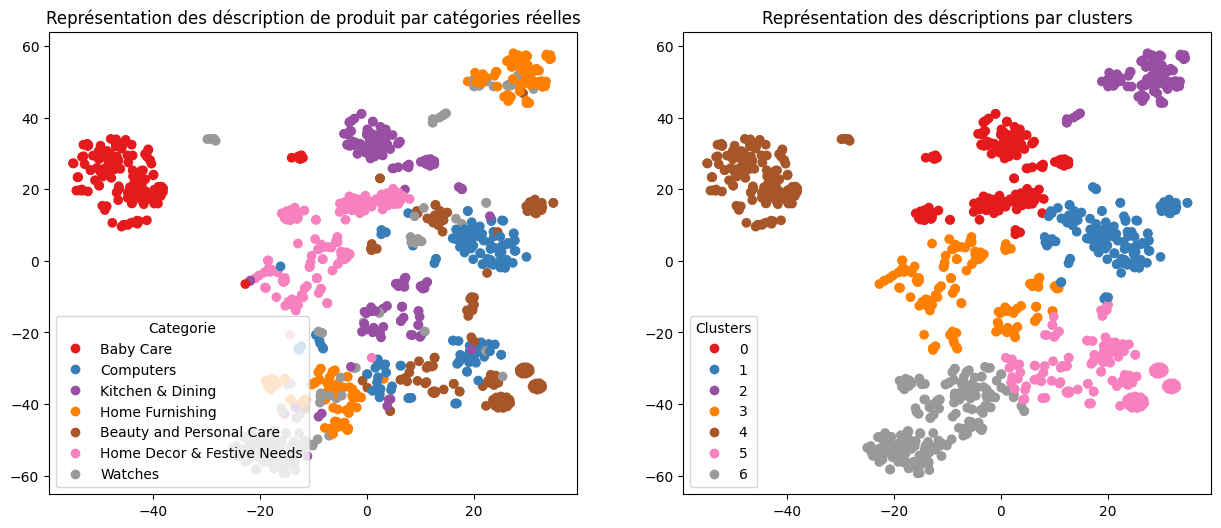

ARI :  0.4226


In [64]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

batch_size = 10
#sentences = data_T['sentence_dl'].to_list()

features_USE = feature_USE_fct(sentences, batch_size)

ARI, X_tsne, labels = ARI_fct(features_USE)

new_row = ['6 USE Universal Sentence Encoder', ARI]
methods_ARI.loc[len(methods_ARI)] = new_row

TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## Resultats final

In [65]:
methods_ARI.sort_values(by=["ARI"],ascending=False)

,Method,ARI
1,2 Tf-idf,0.5389
5,6 USE Universal Sentence Encoder,0.4226
0,1 CountVectorizer,0.3745
3,4 BERT-base-uncased Huggingface,0.3267
4,5 BERT Tensorflow,0.3259
2,3 Word2Vec,0.2818
